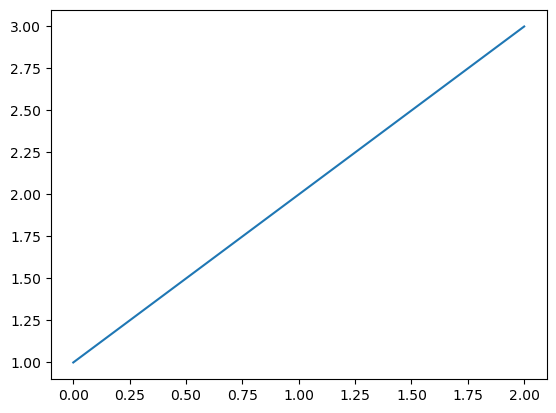

In [1]:
import matplotlib.pyplot as plt

plt.plot([1,2,3])

In [3]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import os
from torchvision import io
import pickle
import sys
import numpy as np
from torch import nn

In [11]:
class BaseHISDataset(Dataset):
    def __init__(self, 
                 images_dir: str,
                 annotations_dir: str):
        """Base loader for hierarchical dataset

        Args:
            images_dir (str): path to source images folder
            annotations_dir (str): path to annotation tree folder            
        """
        super().__init__()
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.images = os.listdir(images_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # read image
        image = io.read_image(str(Path(self.images_dir) / self.images[index])).float()
        image /= 255
        
        
        # read annotations
        with open(str(Path(self.annotations_dir) /
                  self.images[index].replace(".png", ".pkl")), "rb") as f:
            annotation = pickle.load(f)
            

        return image, annotation

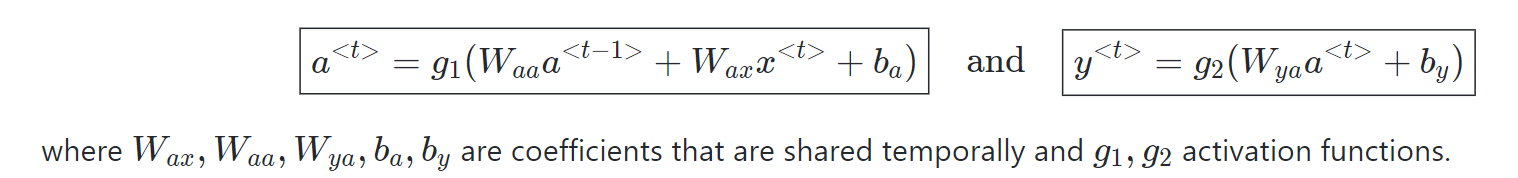

In [32]:
class UnitProcess(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, in_channels*2, 3, 1, 1),
          nn.BatchNorm2d(in_channels*2),
          nn.GELU(),
          nn.Conv2d(in_channels*2, in_channels, 3, 1, 1),
          nn.BatchNorm2d(in_channels),
          nn.GELU(),
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
          nn.GELU()
        )
        
        
    def forward(self, x):
        return self.process(x)
    

class RCNNCell(nn.Module):
    def __init__(self, in_channels, height, width, out_channels=1):
        super().__init__()

        # hidden state
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden', torch.zeros(1, in_channels, height, width))
        
        # output generation
        self.Wya = UnitProcess(in_channels, out_channels)
        
        # hidden state processing  
        self.Waa = UnitProcess(in_channels, in_channels)
        self.Wax = UnitProcess(in_channels, in_channels)
        
        self.bias_x = nn.Parameter(torch.randn(1, in_channels, height, width))
        self.bias_y = nn.Parameter(torch.randn(1, out_channels, height, width))
        
        
    def forward(self, x):
        # calculate state
        hidden_batched = self.hidden.expand(x.shape[0], -1, -1, -1)  
        # hidden_batched = self.hidden
        
        self.hidden = nn.GELU()(self.Waa(hidden_batched) + self.Wax(x) + self.bias_x)
        
       
        # calculate output
        x = nn.GELU()(self.Wya(self.hidden) + self.bias_y)
        
        return x

In [33]:
# test
model = RCNNCell(10, 200, 200)
model(torch.randn(10, 10, 200, 200)).shape

torch.Size([10, 1, 200, 200])

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

In [6]:
dataset = BaseHISDataset("../data/dataset_3/data/", "../data/dataset_3/RCNNAnnotations/")

In [7]:
train_dataset, val_dataset = random_split(
    dataset, [45, 5], torch.Generator().manual_seed(10)
)

In [9]:
import random 

def genAttentionMask(size):
    x, y = size
    ret = np.zeros(size)
    x1, y1 = random.randint(0, x//4-1), random.randint(0, y//4-1)
    w, h = random.randint(y1+10, y-1), random.randint(x1+10, x-1)
    
    ret[x1:h, y1:w] = 1
    
    if random.random() > 0.5:
        ret = ret.T
    return ret

In [10]:
from torchvision.transforms import v2
from torchvision import tv_tensors

transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomResizedCrop((200, 200)),
    # v2.ColorJitter(0.1)
    v2.RandomRotation(10)
])

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RCNNCell(3, 200, 200).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss()
in_channels = 3
height = 200
width = 200

In [ ]:
writer = SummaryWriter(f"./runs/RCNN/r1", comment="RCNN")

In [ ]:
for e in range(10):
    
    epoch_loss = 0
    
    for data in train_dataset:
        image, annotation = data
        image = image.to(device).unsqueeze(dim=0)
        
        # reset state
        model.hidden = torch.ones(1, in_channels, height, width)
        
        # pass input
        optimizer.zero_grad()
        
        output = model(image)
        
        l = 0
        
        for ann in annotation:
            ann = torch.tensor(ann).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
            l += loss(ann, output)
            
            
            output = model(image)
            
        l.backward()
            
        optimizer.step()
        
        epoch_loss += l 
    
    # writer.add_scalar("Loss/train", epoch_loss, e)
    print(f"Epoch {e}: {epoch_loss}")